# Kings County Housing Data Analysis:
## Linear regression prediction of housing prices secondary to housing characteristics 

![King's Conty, Washington](https://d33a4decm84gsn.cloudfront.net/search/2019/places-to-live/counties/king-county-wa_1910.png)

### Packages utilized for this analysis are as follows:

In [4]:
#Import Packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pylab 
import scipy.stats as stats
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import  LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Orginial Dataset 

In [9]:
#Original Dataset
df = pd.read_csv('kc_house_data.csv')

### Data Analysis
On inspection of raw data, the following was noted:
* Out of 23 data columns, 3 contained null values
    * waterfront, view, and yr.renovated
* the id column contained numerous duplications
* the lat column consisted of inconsistent decimal significant figures
* the sqft_basement column contained a significant numner of "?" in place of numerical data
* Several columns consisted of categorical data
    * waterfront, view, condition, and grade
* A few significant outliyers
    * One home in the bedroom column had 33 bedrooms
    * One home had 7.5 bathroom

In [ ]:
df.head() #view of first 5 rows of data

In [ ]:
df.info()

In [ ]:
df.info()

In [ ]:
df.columns

### Dataset cleaning prior to analysis:

In [10]:
# All "?" in sqft_basement column replaced with null values
df = df.replace('?' , np.nan)

# A new data column was created by taking each value in 
#'yr_built' and subtracting from the current year 2019
df['age'] = 2019-df['yr_built']

#In order to provide more manageable values, 'price was divided by 1000, 
# converting 'price' to thousands ($)
df['price1000'] = df['price']/1000

#Due to the large spread of data, and the substantially increased variance 
# as 'price' approached millions, the dataset 'price' was capped at 
# 1,000,000 ie 'price' would include only homes valued at under 1 million dollars
df_Mill = df.loc[df['price'] < 1000000]
df_Mill.describe()


#Columns of interest for <$1,000,000 Homes
dfX= df_Mill[['sqft_living', 'bathrooms', 'floors', 'grade'
              , 'sqft_living15', 'age', 'zipcode', 'view']]
dfY= df_Mill['price1000']

#Dataframe with Dummy Variables
dfXDummy1 = pd.get_dummies(dfX, columns=['view','zipcode'])
dfXDummy1 = dfXDummy1.drop(['view_0.0','zipcode_98001'], axis=1)
dfXDummy1.head()

#####Most relevant zipcodes
relevant_zip = dfXDummy1[['zipcode_98040', 'zipcode_98004', 'zipcode_98039', 
                          'zipcode_98005', 'zipcode_98075', 'zipcode_98112', 
                          'zipcode_98119', 'zipcode_98006', 'zipcode_98109', 
                          'zipcode_98102', 'zipcode_98074', 'zipcode_98105', 
                          'zipcode_98199', 'zipcode_98033', 'zipcode_98077', 'zipcode_98052', 'zipcode_98053']]
relevant_zip.head()

#######Final Data
X= dfXDummy1[['sqft_living', 'bathrooms', 'floors', 'grade', 
              'sqft_living15', 'age']]
Y= dfY

### Preliminary Normality Check

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c277b4c88>,
      dtype=object)

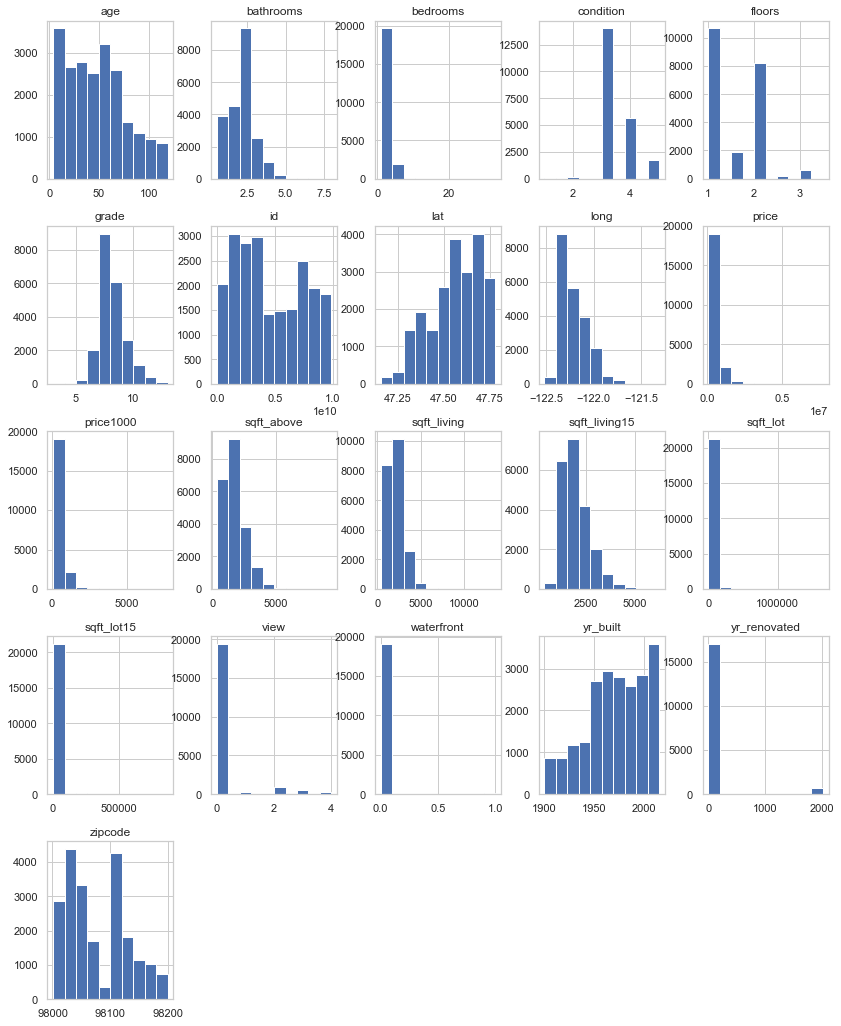

In [11]:
df.hist(figsize=(14,18))

### Box plot illustrating outliers such as a house with 33 bedrooms

Text(0.5,1,'Number of bedrooms in homes sold')

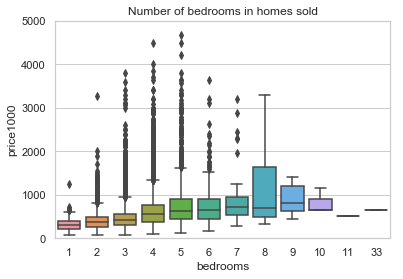

In [12]:
sns.set(style="whitegrid")
sns.boxplot(x=df["bedrooms"],y=df["price1000"])
plt.ylim(0, 5000)
plt.title("Number of bedrooms in homes sold")

### Visual inspection of predictor multicollinearity via heatmap 

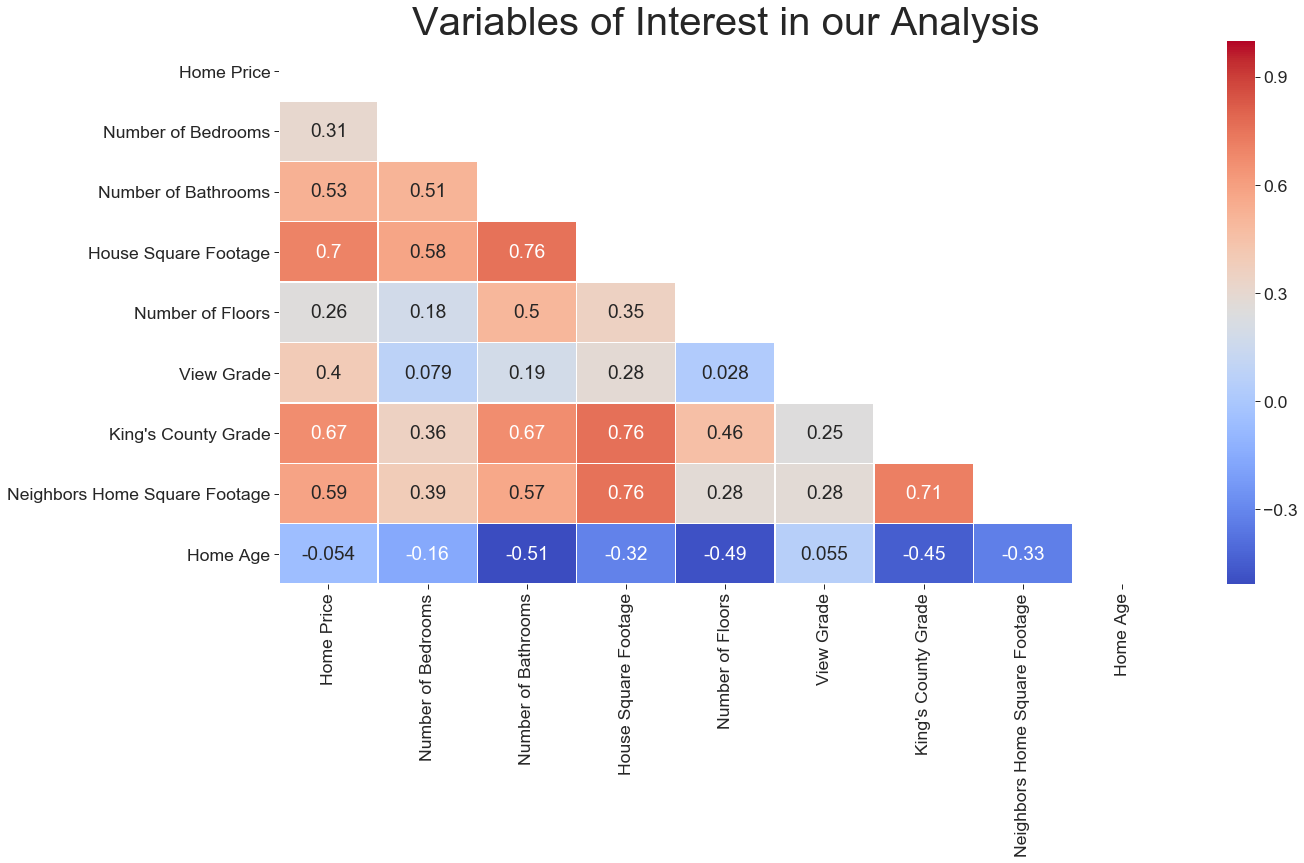

In [98]:
corr = new_data.corr()
plt.figure(figsize=(20,10))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set_context("paper", font_scale=2)
plt.title('Variables of Interest in our Analysis', fontsize=40)
sns.heatmap(new_data.corr(),annot=True, linewidth=.5, cmap="coolwarm", mask=mask)

In [56]:
new_data = df.rename(columns = {'price': "Home Price", 'bedrooms': "Number of Bedrooms", 'bathrooms': "Number of Bathrooms", 
                                             'sqft_living': "House Square Footage", 'floors': "Number of Floors", 'view': "View Grade", 'grade' : "King's County Grade", 'sqft_living15' : "Neighbors Home Square Footage", 'age' : "Home Age"})
new_data = new_data.drop(['sqft_lot', 'id', 'waterfront', 'condition', 'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_lot15', 'price1000'], axis=1)

### Running the regression model

From our regression model, with 'price1000' as the dependent/target variable and explanatory variables of 'sqft_living', 'bedrooms', 'bathrooms', 'floors', 'sqft_lot', 'grade', 'sqft_living15', 'sqft_lot15', 'age',
we obtained an R squared value was 0.551. 

In [18]:
#Regression Model
X = sm.add_constant(X)# adding a constant
model=sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price1000   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     4058.
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        09:04:49   Log-Likelihood:            -1.2663e+05
No. Observations:               20107   AIC:                         2.533e+05
Df Residuals:                   20100   BIC:                         2.533e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -663.4939      9.899    -67.026      0.000    -682.897    -644.091
sqft_living       0.0511      0.002     22.061      0.000       0.047       0.056
bathrooms        29.7995      2.182     13.655      0.000      25.522      34.077
floors           39.1622      2.166     18.081      0.000      34.917      43.408
grade            89.8342      1.465     61.333      0.000      86.963      92.705
sqft_living15     0.0541      0.002     22.374      0.000       0.049       0.059
age               2.8027      0.042     66.566      0.000       2.720       2.885
==============================================================================
Omnibus:                      431.653   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              490.746
Skew:                           0.323   Prob(JB):                    2.73e-107
Kurtosis:                       3.411   Cond. No.                     3.09e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note: Our Model ran with all explanatory variables in the X dataframe, and the target variable (House price in thousands of dollars) in the Y dataframe. All explanatory variables are significant.

### Testing Distribution of Residuals
A Q-Q plot was done, illustrating that our model residuals were normally distributed and the assumptions required for our model to be reliable were met.

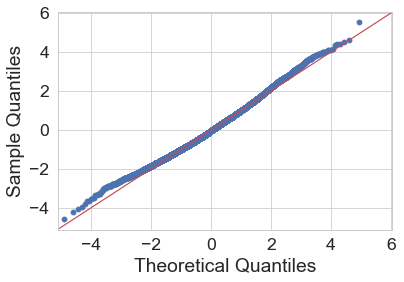

In [19]:
#Residual Plot
residuals = model.resid
fig = sm.qqplot(residuals, stats.t, fit=True, line='45')
plt.show()

### Training and testing the data

We performed a 5-fold split of our dataset with 80% of the data in training and 20% of the data in testing.

In [21]:
#Train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

lm = LinearRegression()
model = lm.fit(X_train, Y_train)
predictions = lm.predict(X_test)

lm.score(X_train, Y_train)

0.5465188256867829

### Predicted Performance of House Sale Price

Below is a visualization of our prediction line from the training data compared to the testing data.

/Users/Mango/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Trained Regression')

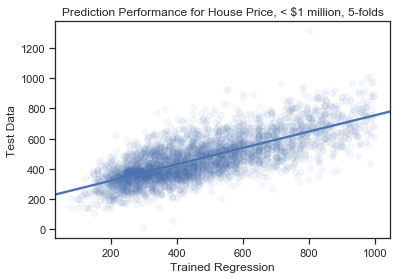

In [22]:
sns.set(style='ticks')
sns.regplot(Y_test, y=predictions, scatter_kws={'alpha':0.05});
plt.title('Prediction Performance for House Price, < $1 million, 5-folds')
plt.ylabel('Test Data')
plt.xlabel('Trained Regression')

We used Root Mean Squared Error to evaluate model performance.  On average, our trained regression model mis-estimated the true values of homes in the test data by $131,000.

In [23]:
#On Average our model missed each data point by $131,000
metrics.mean_squared_error(Y_test, predictions)**0.5

131.96108681794277

In [14]:
MSEs = cross_val_score(lm, X, y=Y, scoring='neg_mean_squared_error', cv=10)
RMSE = (MSEs*-1)**0.5
print(RMSE)

[131.86508051 134.14601432 133.83294761 129.96903792 129.35030657
 128.62966488 131.03051626 133.22863926 132.86070996 135.89446624]


### Regression Analysis with categorical values
Our linear regression model was repeated, but this time with the inclusion of categorical variables (view and zipcode) via dummy variables

In [101]:
dfXDummy1.shape

(20107, 79)

In [15]:
X1= dfXDummy1
Y1= dfY

X1 = sm.add_constant(X1)# adding a constant
model1=sm.OLS(Y, X1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price1000   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     1147.
Date:                Thu, 09 May 2019   Prob (F-statistic):               0.00
Time:                        17:37:14   Log-Likelihood:            -1.1742e+05
No. Observations:               20107   AIC:                         2.350e+05
Df Residuals:                   20027   BIC:                         2.356e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -351.9106      8.071    -43.601      0.000    -367.731    -336.091
sqft_living       0.0891      0.002     59.021      0.000       0.086       0.092
bathrooms        10.4835      1.406      7.456      0.000       7.727      13.240
floors            0.0086      1.498      0.006      0.995      -2.927       2.944
grade            46.4428      0.996     46.627      0.000      44.490      48.395
sqft_living15     0.0381      0.002     22.747      0.000       0.035       0.041
age               0.8152      0.033     25.070      0.000       0.751       0.879
view_1.0         47.4121      5.334      8.888      0.000      36.956      57.868
view_2.0         49.1039      3.200     15.345      0.000      42.832      55.376
view_3.0         71.8240      4.838     14.845      0.000      62.341      81.307
view_4.0        173.6434      7.622     22.782      0.000     158.704     188.583
zipcode_98002    12.6631      7.378      1.716      0.086      -1.799      27.125
zipcode_98003    -9.1416      6.648     -1.375      0.169     -22.172       3.889
zipcode_98004   476.4774      8.501     56.049      0.000     459.815     493.140
zipcode_98005   317.3658      8.287     38.297      0.000     301.123     333.609
zipcode_98006   261.1887      6.194     42.170      0.000     249.049     273.329
zipcode_98007   247.3902      8.458     29.248      0.000     230.811     263.970
zipcode_98008   234.0668      6.780     34.526      0.000     220.778     247.355
zipcode_98010   108.7740      9.424     11.542      0.000      90.303     127.246
zipcode_98011   137.0527      7.440     18.422      0.000     122.471     151.635
zipcode_98014   131.2463      8.759     14.985      0.000     114.079     148.414
zipcode_98019   106.2619      7.499     14.170      0.000      91.563     120.961
zipcode_98022    28.6355      7.037      4.069      0.000      14.842      42.429
zipcode_98023   -25.1245      5.773     -4.352      0.000     -36.440     -13.809
zipcode_98024   166.8150     10.765     15.496      0.000     145.714     187.916
zipcode_98027   191.0343      6.121     31.210      0.000     179.037     203.032
zipcode_98028   125.9201      6.648     18.942      0.000     112.890     138.950
zipcode_98029   224.3133      6.522     34.395      0.000     211.530     237.096
zipcode_98030     4.7181      6.813      0.692      0.489      -8.636      18.073
zipcode_98031    11.8622      6.689      1.773      0.076      -1.249      24.974
zipcode_98032   -11.1297      8.661     -1.285      0.199     -28.107       5.847
zipcode_98033   305.6161      6.307     48.458      0.000     293.254     317.978
zipcode_98034   177.8213      5.714     31.119      0.000     166.621     189.021
zipcode_98038    46.6946      5.602      8.335      0.000      35.714      57.675
zipcode_98039   630.6376     37.552     16.794   

In [17]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size=0.2)

lm = LinearRegression()
model = lm.fit(X_train1, Y_train1)
predictions = lm.predict(X_test1)

lm.score(X_train1, Y_train1)

0.8166069518386387

In [18]:
MSEs1 = cross_val_score(lm, X1,Y1, scoring='neg_mean_squared_error', cv=10)
RMSEs1 = (MSEs1*-1)**0.5
print(RMSEs1)

[83.85768923 88.33768146 83.36782907 82.9558431  81.09160222 82.05150065
 82.796006   81.50038961 86.81897319 85.10965661]


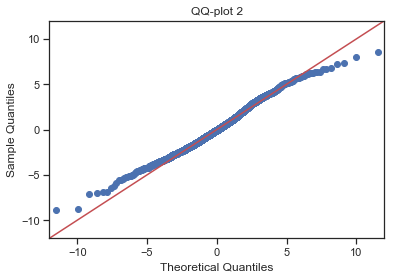

In [19]:
residuals1 = model1.resid
fig = sm.qqplot(residuals1, stats.t, fit=True, line='45')
plt.title('QQ-plot 2')
plt.show()

### Final Recommendations

We would give the following recommendations to home owners in King's county looking to maximize the final sale value of their home:

* Inreasing your avialble living space, on average increases home value by $51 per sqft
    
    * Make use of deadspace between walls and under staircases
    
    * When possible, consider light additions to your home such as sunrooms
    
* There is a very strong correlation between bathroom number and increased housing sale price
    * Observed about $30,000 increase in sale price per bathroom increase
    * Increase the number of bathrooms in your home, even if converting 1/4 baths to 1/2 baths and 1/2 baths to full etc.
    
* Your neighbors living space size has an effect on your home value
    * The increasing of living space by your neighbors in their own homes will increase the return you get for your home

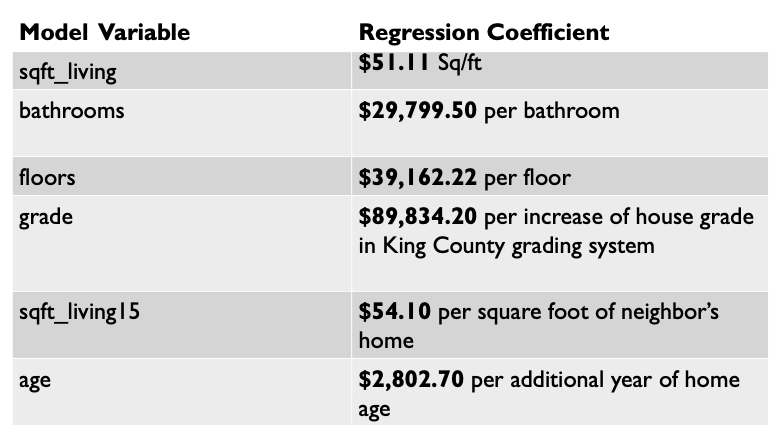